In [1]:
import tensorflow as tf

In [2]:
import numpy as np

X = np.load('../mount/Data_Manipulation_datasets/processed_X.npy')
Y = np.load('../mount/Data_Manipulation_datasets/processed_Y.npy')

In [3]:
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(60,)),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(4, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(2, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.01))
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           132 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            10 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,078 (47.18 KB)

 Trainable params: 12,078 (47.18 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
from sklearn.metrics import precision_score, recall_score
model.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
              metrics=[ 'accuracy', tf.keras.metrics.Precision(class_id=0), tf.keras.metrics.Recall(class_id=0)])

In [11]:
epoch = 50 

history = model.fit(X, Y, 
                    epochs=epoch, 
                    validation_split=0.2,
                    verbose=2)

Epoch 1/50
824/824 - 4s - 5ms/step - accuracy: 0.9123 - loss: 0.2454 - precision_1: 0.8520 - recall_1: 0.0678 - val_accuracy: 0.9079 - val_loss: 0.2529 - val_precision_1: 0.8600 - val_recall_1: 0.0679
Epoch 2/50
824/824 - 1s - 1ms/step - accuracy: 0.9128 - loss: 0.2455 - precision_1: 0.8712 - recall_1: 0.0671 - val_accuracy: 0.9080 - val_loss: 0.2531 - val_precision_1: 0.8627 - val_recall_1: 0.0879
Epoch 3/50
824/824 - 1s - 1ms/step - accuracy: 0.9120 - loss: 0.2456 - precision_1: 0.8975 - recall_1: 0.0702 - val_accuracy: 0.9089 - val_loss: 0.2515 - val_precision_1: 0.8711 - val_recall_1: 0.0677
Epoch 4/50
824/824 - 1s - 2ms/step - accuracy: 0.9114 - loss: 0.2452 - precision_1: 0.8674 - recall_1: 0.0680 - val_accuracy: 0.9047 - val_loss: 0.2555 - val_precision_1: 0.8626 - val_recall_1: 0.0900
Epoch 5/50
824/824 - 1s - 2ms/step - accuracy: 0.9113 - loss: 0.2456 - precision_1: 0.8668 - recall_1: 0.0685 - val_accuracy: 0.9086 - val_loss: 0.2516 - val_precision_1: 0.8616 - val_recall_1: 0.

#### functions for running metric and saving the model

In [67]:
import tensorflow as tf 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt
import os

def evaluation_metrics(Y, Y_pred, Y_prob, save_plots_dir=None):
    tp, fn, fp, tn = confusion_matrix(Y, Y_pred).ravel()
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * precision * recall / (precision + recall)
    accuracy = (tp + tn) / (tp + fn + fp + tn)
    AUC = roc_auc_score(Y, Y_prob[:, 1])
    
    print("||>> Precision: ", precision)
    print("||>> Recall: ", recall)
    print("||>> F1: ", f1)
    print("||>> Accuracy: ", accuracy)
    print("||>> AUC: ", AUC)
    
    # ROC curve
    fpr, tpr, thresholds = roc_curve(Y, Y_prob[:, 1])
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.title('ROC Curve')
    if save_plots_dir:
        plt.savefig(os.path.join(save_plots_dir, 'roc_curve.png'))
    else:
        plt.show()
    
    # Precision-Recall curve
    precisions, recalls, thresholds = precision_recall_curve(Y, Y_prob[:, 0], pos_label=0)
    plt.cla()
    plt.plot(recalls, precisions)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve') 
    if save_plots_dir:
        plt.savefig(os.path.join(save_plots_dir, 'precision_recall_curve.png'))
    else:
        plt.show()
    
    AUPRC = auc(recalls, precisions)
    print("||>> AUPRC: ", AUPRC)
    
    return precision, recall, f1, accuracy, AUC, AUPRC


def save_model_and_performance(model, X, Y, model_name, if_test_data_provided=False):
    model_dir = os.path.join('../mount/trained_models', model_name)
    os.makedirs(model_dir)
    model.save('../mount/trained_models/{}/model.keras'.format(model_name))
    
    if if_test_data_provided:
        X_test, Y_test = X, Y
    else:
        _, X_test, _, Y_test = train_test_split(X, Y, test_size=0.2)
    
    Y_prob = model.predict(X_test)
    Y_pred = np.argmax(Y_prob, axis=1)
    
    precision, recall, f1, accuracy, AUC, AUPRC = evaluation_metrics(Y_test, Y_pred, Y_prob, save_plots_dir=model_dir)
    with open(os.path.join(model_dir, 'metrics.txt'), 'w') as f:
        f.write("Precision: {}\n".format(precision))
        f.write("Recall: {}\n".format(recall))
        f.write("F1: {}\n".format(f1))
        f.write("Accuracy: {}\n".format(accuracy))
        f.write("AUC: {}\n".format(AUC))
        f.write("AUPRC: {}\n".format(AUPRC))

#### checking and saving the model

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
||>> Precision:  0.6148282097649186
||>> Recall:  0.47752808988764045
||>> F1:  0.5375494071146244
||>> Accuracy:  0.9112021857923497
||>> AUC:  0.9394113409336015
||>> AUPRC:  0.6313264901749839


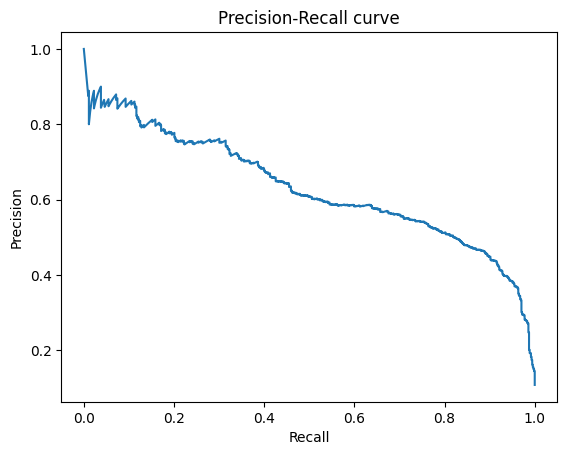

In [24]:
model_name = "NN_1"
save_model_and_performance(model, X, Y, model_name)

**Take-away** : - Even NN is showing similar performance as the different ML models, even slightly worses than the XG-Boost model

# Approach 2: Train the model with even number of samples from each class

In [27]:
# Same model architecture to be used 
import tensorflow as tf 

model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(60,)),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(4, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(2, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.01))
])

model.summary()

model.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
              metrics=[ 'accuracy', tf.keras.metrics.Precision(class_id=0), tf.keras.metrics.Recall(class_id=0)])

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 4)              │           132 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │            10 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,078 (47.18 KB)

 Trainable params: 12,078 (47.18 KB)

 Non-trainable params: 0 (0.00 B)

In [70]:
from sklearn.model_selection import train_test_split
import numpy as np

num_of_epochs = 150

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1) 

X_class_0 = X_train[ Y_train == 0 ]
Y_class_0 = Y_train[ Y_train == 0 ]

num_of_class_0 = len(Y_class_0)

XY = np.concatenate((X, Y.reshape(-1,1)), axis=1)

for i in range(num_of_epochs):
    XY = XY[ XY[:, -1] == 1 ]
    XY_sels = np.random.choice(XY.shape[0], num_of_class_0)
    XY_class_1 = XY[ XY_sels ]
    X_class_1 = XY_class_1[:, :-1]
    Y_class_1 = XY_class_1[:, -1]
    X_batch = np.concatenate((X_class_0, X_class_1), axis=0)
    Y_batch = np.concatenate((Y_class_0, Y_class_1), axis=0)
    model.fit(X_batch, 
              Y_batch, 
              epochs=1, 
              validation_split=0.1,
              verbose=2)
    print(f"|| >> End of epoch {i} << ||")

187/187 - 0s - 2ms/step - accuracy: 0.8875 - loss: 0.3666 - precision_2: 0.4468 - recall_2: 0.5841 - val_accuracy: 0.8341 - val_loss: 0.4258 - val_precision_2: 1.0000 - val_recall_2: 0.1629
|| >> End of epoch 0 << ||
187/187 - 0s - 2ms/step - accuracy: 0.8808 - loss: 0.3762 - precision_2: 0.4407 - recall_2: 0.5811 - val_accuracy: 0.8084 - val_loss: 0.4815 - val_precision_2: 1.0000 - val_recall_2: 0.1855
|| >> End of epoch 1 << ||
187/187 - 0s - 2ms/step - accuracy: 0.8800 - loss: 0.3752 - precision_2: 0.3932 - recall_2: 0.5863 - val_accuracy: 0.8235 - val_loss: 0.4610 - val_precision_2: 1.0000 - val_recall_2: 0.1689
|| >> End of epoch 2 << ||
187/187 - 0s - 2ms/step - accuracy: 0.8825 - loss: 0.3680 - precision_2: 0.4392 - recall_2: 0.5896 - val_accuracy: 0.8356 - val_loss: 0.4390 - val_precision_2: 1.0000 - val_recall_2: 0.1614
|| >> End of epoch 3 << ||
187/187 - 0s - 2ms/step - accuracy: 0.8850 - loss: 0.3700 - precision_2: 0.4761 - recall_2: 0.5868 - val_accuracy: 0.8507 - val_loss

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step
||>> Precision:  0.4042672655811342
||>> Recall:  0.9574468085106383
||>> F1:  0.568495854717726
||>> Accuracy:  0.8340922890103218
||>> AUC:  0.9451496944861679
||>> AUPRC:  0.6538045951015488


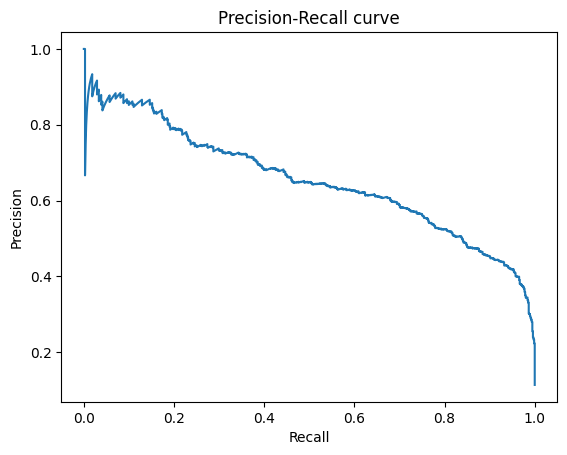

In [72]:
model_name = "NN_balaced_1"
save_model_and_performance(model, X, Y, model_name)